# Introdução aos Processos Estocásticos


> **Referência**  
> Papoulis, A., & Pillai, S. U. (2002). *Probability, Random Variables and Stochastic Processes* (4th ed.). McGraw-Hill.


In [ ]:
%pip install yfinance pandas

# 1. Aquisição dos dados

Neste notebook, vamos analisar se a série histórica de preços ajustados de uma ação segue um processo estocástico de Markov de primeira ordem.  

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from scipy.stats import ks_2samp, chi2_contingency
import yfinance as yf
import pandas as pd


In [12]:
# Define the stock ticker symbol and date range
ticker_symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-07-01'

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Retrieve historical data
df_historical_data = ticker.history(start=start_date, end=end_date)

df_historical_prices = df_historical_data['Close']
df_historical_prices.head()

,Close
Date,
2015-01-02 00:00:00-05:00,24.288580
2015-01-05 00:00:00-05:00,23.604330
2015-01-06 00:00:00-05:00,23.606554
2015-01-07 00:00:00-05:00,23.937571
2015-01-08 00:00:00-05:00,24.857307


# 2. Análise Exploratória da Série Temporal


In [13]:
df_historical_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2638.000000,2638.000000,2638.000000,2638.000000,2.638000e+03,2638.000000,2638.000000
mean,99.617474,100.709670,98.603402,99.710169,1.143558e+08,0.003100,0.001516
std,69.021725,69.780949,68.328503,69.101652,6.814643e+07,0.024933,0.077879
min,20.569746,20.951429,20.448617,20.647457,2.323470e+07,0.000000,0.000000
25%,36.035295,36.273373,35.716251,36.074789,6.841305e+07,0.000000,0.000000
50%,74.138497,75.333190,73.481132,74.771553,9.734785e+07,0.000000,0.000000
75%,160.538161,162.681994,158.330694,160.798115,1.399191e+08,0.000000,0.000000
max,257.568678,259.474086,257.010028,258.396667,6.488252e+08,0.260000,4.000000


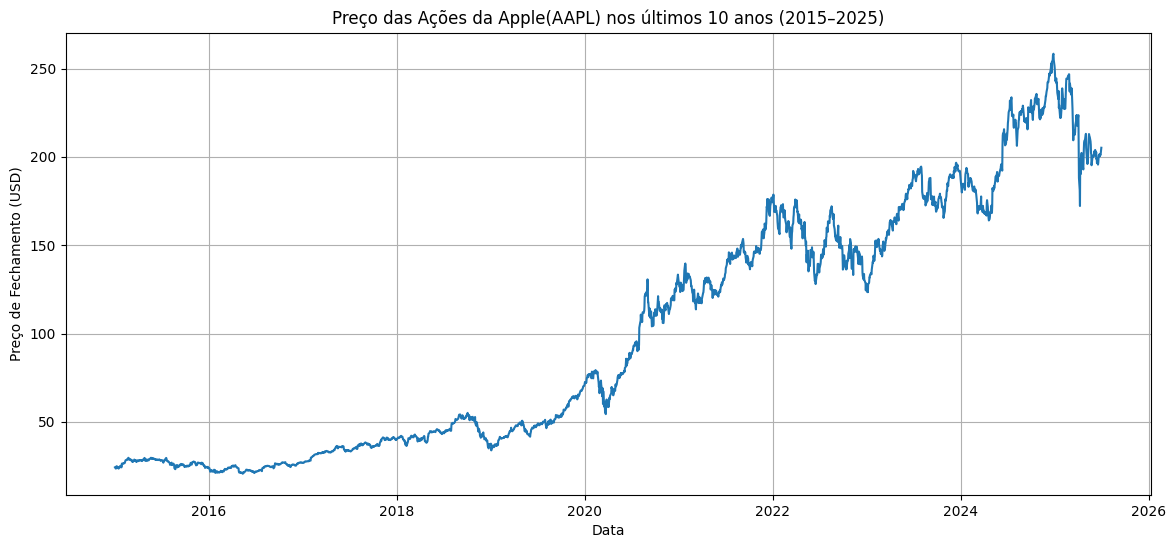

In [14]:
# @title Preço de Fechamento da Ação AAPL em (2015–2025)

plt.figure(figsize=(14, 6))
plt.plot(df_historical_data.index, df_historical_data['Close'])
plt.title("Preço das Ações da Apple(AAPL) nos últimos 10 anos (2015–2025)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento (USD)")
plt.grid(True)
plt.show()

# 3. Testes de Estacionaridade (Amplitude) nos Preços Brutos

## Teoria: Ampla Estacionaridade

Para que um processo \(\{X_t\}\) seja **amplamente estacionário**, devem valer:

1. **Média constante**  
   $$
     \mu_X(t) = \mathbb{E}[X_t] = \mu,\quad \forall\,t.
   $$

2. **Variância constante**  
   $$
     \mathrm{Var}[X_t]
     = \mathbb{E}\bigl[(X_t - \mu)^2\bigr]
     = \sigma^2,\quad \forall\,t.
   $$

3. **Covariância depende apenas da defasagem**  
   $$
     \mathrm{Cov}(X_t, X_{t+h})
     = \mathbb{E}\bigl[(X_t - \mu)(X_{t+h} - \mu)\bigr]
     = C(h),
   $$
   ou seja, independe de \(t\).

---

#### Testes Estatísticos

- **ADF (Augmented Dickey–Fuller)**  
  - *Hipótese nula* $H_{0}$ : existe raiz unitária (⇒) série **não** estacionária.  
  - Rejeitamos $H_0$ se o *p*-valor do ADF for **< 0,05**, indicando estacionaridade.

- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**  
  - *Hipótese nula* $H_0$: série **é** estacionária.  
  - Rejeitamos $H_0$ se o *p*-valor do KPSS for **< 0,05**, indicando não-estacionaridade.

> **Observação:** Idealmente, para confirmar ampla estacionaridade, queremos  
> - ADF com *p*-valor **baixo** (rejeita não-estacionaridade)  
> - KPSS com *p*-valor **alto** (não rejeita estacionaridade)


In [15]:
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

# Teste ADF
adf_stat, adf_p, *_ = adfuller(df_historical_prices.dropna())
print(f'ADF preço: estatística={adf_stat:.4f}, p-valor={adf_p:.4f}')

# Teste KPSS
kpss_stat, kpss_p, *_ = kpss(df_historical_prices.dropna(), nlags='auto')
print(f'KPSS preço: estatística={kpss_stat:.4f}, p-valor={kpss_p:.4f}')


ADF preço: estatística=-0.3312, p-valor=0.9210
KPSS preço: estatística=8.1376, p-valor=0.0100


/tmp/ipython-input-15-267938250.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(df_historical_prices.dropna(), nlags='auto')


## Transformação em Retornos Logarítmicos

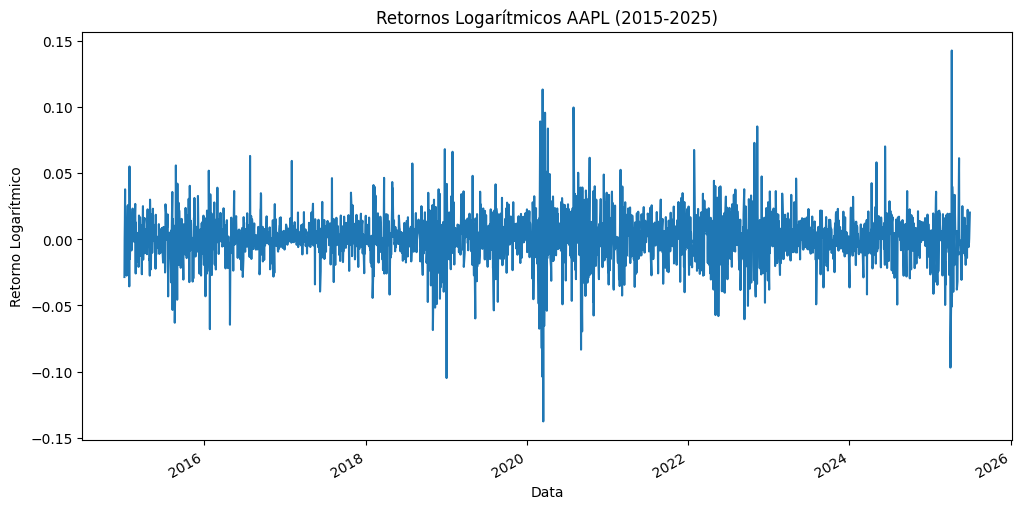

ADF retornos: estatística=-16.3610, p-valor=0.0000
KPSS retornos: estatística=0.0839, p-valor=0.1000


/tmp/ipython-input-16-1579999991.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(returns, nlags='auto')


In [16]:
# Cálculo dos retornos logarítmicos
returns = np.log(df_historical_prices).diff().dropna()

plt.figure(figsize=(12,6))
returns.plot(title="Retornos Logarítmicos AAPL (2015-2025)")
plt.xlabel('Data')
plt.ylabel('Retorno Logarítmico')
plt.show()

# Realizar novamente os testes de ADF e KPSS nos retornos
adf_stat, adf_p, *_ = adfuller(returns)
print(f'ADF retornos: estatística={adf_stat:.4f}, p-valor={adf_p:.4f}')

kpss_stat, kpss_p, *_ = kpss(returns, nlags='auto')
print(f'KPSS retornos: estatística={kpss_stat:.4f}, p-valor={kpss_p:.4f}')


## Estacionaridade Estrita

In [21]:
import numpy as np
from scipy.stats import ks_2samp

# Dividindo a série em dois períodos (metade da série)
mid = len(df_historical_prices) // 2
subset1 = df_historical_prices[:mid]
subset2 = df_historical_prices[mid:]

# Teste de Kolmogorov-Smirnov para comparar as distribuições
ks_stat, ks_p = ks_2samp(subset1, subset2)

print(f"Teste KS: estatística={ks_stat:.4f}, p-valor={ks_p:.4f}")


Teste KS: estatística=0.9651, p-valor=0.0000


In [20]:
import numpy as np
from scipy.stats import ks_2samp

# Dividindo a série em dois períodos (metade da série)
mid = len(returns) // 2
subset1 = returns[:mid]
subset2 = returns[mid:]

# Teste de Kolmogorov-Smirnov para comparar as distribuições
ks_stat, ks_p = ks_2samp(subset1, subset2)

print(f"Teste KS: estatística={ks_stat:.4f}, p-valor={ks_p:.4f}")


Teste KS: estatística=0.0590, p-valor=0.0187


## Markov

In [25]:
from scipy.stats import chi2_contingency

# Discretizando os retornos
states = pd.qcut(returns, 4, labels=False)

# Matriz de transição
trans_matrix = pd.crosstab(states.shift(1), states, normalize='index').fillna(0)

# Verificando a dependência de ordem superior
contingency_table = pd.crosstab([states.shift(2), states.shift(1)], states)
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Resultado
print(f'Matriz de Transição:\n{trans_matrix}')
print(f"\nChi2 Stat: {chi2_stat:.4f}, p-valor: {p_val:.4f}")


Matriz de Transição:
Close         0         1         2         3
Close                                        
0.0    0.289394  0.195455  0.215152  0.300000
1.0    0.235205  0.265554  0.277693  0.221548
2.0    0.221548  0.289833  0.262519  0.226100
3.0    0.253799  0.249240  0.244681  0.252280

Chi2 Stat: 61.4193, p-valor: 0.0521
